In [ ]:
import csv
import os
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import random
import dask.dataframe as dd
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile
import pandas as pd
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Max cpu detected: {}'.format(multiprocessing.cpu_count()))
#npartitions = multiprocessing.cpu_count()

Max cpu detected: 2


In [ ]:
if tf.config.list_physical_devices('GPU'):
    print('GPU available ;)')
else:
    print('No GPU detected...when it comes to training please set the accelerator to use a GPU')

GPU available ;)


In [6]:
data_path = '/content/drive/MyDrive/Internship/new_combined_tweets_with_sentiment_labeled 2.csv'

@dataclass
class CONFIG():
  """
  """
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 100
  training_split = .9

Config = CONFIG()

data = pd.read_csv(data_path,
                   encoding = "ISO-8859-1")

print('Dataset size {}'.format(len(data)))
print('Dataset first five rows:\n{}'.format(data.head()))

Dataset size 100
Dataset first five rows:
                                              inputs  outputs
0  @TimesAlgebraIND Congratulations shreyasi @Riv...      5.0
1  ð© Join @Rivalz_AI DePIN in pioneering the A...      0.0
2  @kyle_chasse Offcourse not!! @AnyInuCoin is in...      5.0
3  Super excited to announce that Iâm now a CAR...     10.0
4  WTF? AI IS ONLY HYPED UP DUE TO GREEDY COMPANI...    -10.0


Original DataFrame:
                                                 text  target
0   @TimesAlgebraIND Congratulations shreyasi @Riv...     5.0
1   ð© Join @Rivalz_AI DePIN in pioneering the A...     0.0
2   @kyle_chasse Offcourse not!! @AnyInuCoin is in...     5.0
3   Super excited to announce that Iâm now a CAR...    10.0
4   WTF? AI IS ONLY HYPED UP DUE TO GREEDY COMPANI...   -10.0
..                                                ...     ...
95  I have joined @KIPprotocol 'The Uprising' camp...     5.0
96  @CIFi_ai What if I tell you that @CIFi_ai is m...    10.0
97  T4 Join me at @AILayerXYZ, the pioneering #AI-...     5.0
98  @kagatoASUKA89 @DawgDaze_Gaming @Thapurppp @Wa...     0.0
99                 @prince_princi11 This AI generated     0.0

[100 rows x 2 columns]


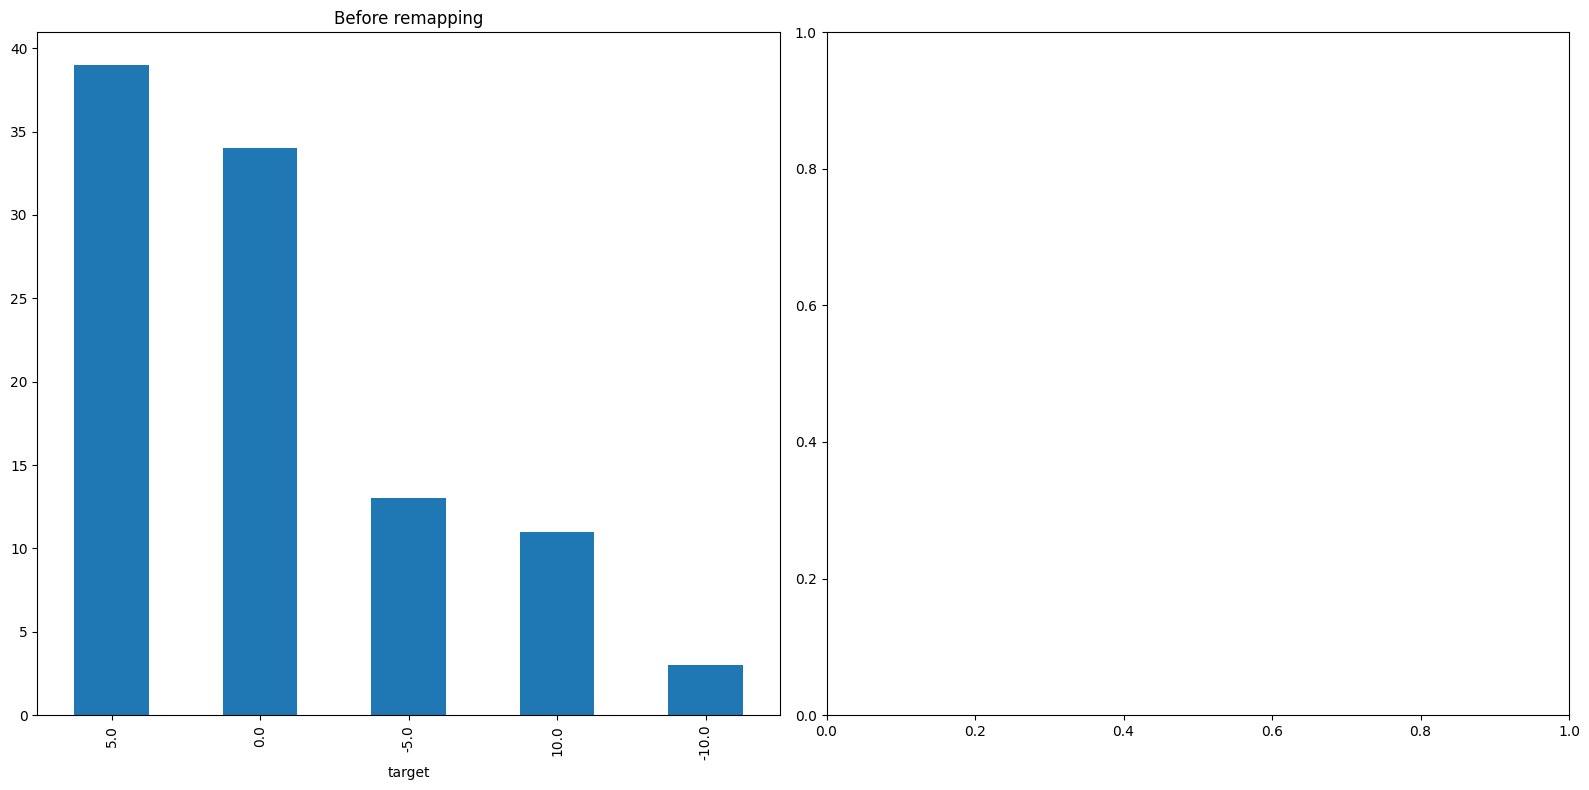

In [9]:
data.rename(columns={data.columns[0]: 'text', data.columns[1]: 'target'}, inplace=True)
fig, (ax1, ax2) = plt.subplots(ncols=2,
                               figsize = (16, 8))

data.target.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Before remapping')
print("Original DataFrame:")
print(data)

# Function to rewrite values
def rewrite_values(val):
    if val in [5, 10]:
        return 1
    elif val in [-5, -10]:
        return 0
    elif val in [0]:
        return val

# Create a new column to identify rows with original zero values
data['original_zero'] = data['target'] == 0

# Apply the rewrite function
data['target'] = data['target'].apply(rewrite_values)

# Remove rows where the original value was zero
data = data[data['original_zero'] == False]

# Drop the helper column
data = data.drop(columns=['original_zero'])
plt.tight_layout()

In [10]:
# Sample text to check appearance of special characters
stop_words = stopwords.words('english')
porter = nltk.stem.PorterStemmer()
remove_links = "https?:\S+|http?:\S|[0-9]+"
rep_elipse = "\.{2,}"
stop_list = stop_words + list(string.punctuation)

In [11]:
def preprocess_tweet(tweet: str,
                     stemmer: object,
                     remove_links_regex,
                     reduce_elipses_regex):
  """
  """
  tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,
                                                 reduce_len=True)
  # remove links and numbers

  tweet = re.sub(remove_links_regex, '', str(tweet))
  # Tokenize
  tweet = tweet_tokenizer.tokenize(tweet)
  # Remove stop words
  tweet = [stemmer.stem(token.lower().strip()) for token in tweet if token not in stop_list]
  tweet =  ' '.join(tweet)

  # Replace elipse (two or more .. with ..)
  tweet = re.sub(reduce_elipses_regex, '..', str(tweet))

  return tweet

In [12]:
test = data.head()
test = test['text'].apply(lambda x: preprocess_tweet(x, porter, remove_links, rep_elipse))
print('Before: {}'. format(list(data['text'][:5])))
print('After: {}'. format(list(test[:5])))

Before: ['@TimesAlgebraIND Congratulations shreyasi @Rivalz_AI', '@kyle_chasse Offcourse not!! @AnyInuCoin is in the green in 17 chains ð\x9f\x91\x8cð\x9f\x94¥ð\x9f\x92\x9c #ANYINU #AI https://t.co/hwbetZYPTW', 'Super excited to announce that Iâ\x80\x99m now a CARV Nodes Owner, joining the mission to build a user-owned internet! ð\x9f\x9a\x80 CARV is the largest modular data layer for gaming and AI. Learn more about CARV @carv_official https://t.co/MvGZo4roMp #CARVNode #CARV https://t.co/V3ybOHussR', "WTF? AI IS ONLY HYPED UP DUE TO GREEDY COMPANIES WHO WANT MORE AND MORE MONEY. WELL, LET'S SEE WHO'S LAUGHING WHEN ALL OUR MOVIES AND MUSIC ARE MADE OUT OF SOULLESS AI AND OVERLAP BECAUSE THEY CAN'T THINK FOR THEMSELVES- https://t.co/YJ4cM3SS9E", 'https://t.co/EIKhzcGOn1 Object]?referralCode=6DoNYxJxFbNaNDiscover the wonders of Starry AI! Join the conversation with our incredible AI chatbot now! #Starrynift #AI #Chatbot']
After: ['congratul shreyasi', 'offcours green chain ð \x9f \x91 \x8

In [13]:
def preprocess_tweet_df(dd:object):
  """
  """
  dd['text'] = data['text'].map(lambda tweet: preprocess_tweet(tweet,
                                                               porter,
                                                               remove_links,
                                                               rep_elipse))

  return dd

In [14]:
print('Some stop word examples ... {}'.format(list(stop_words[:10])))

Some stop word examples ... ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [15]:
X, y  = data['text'].tolist(), data.pop('target').to_numpy()

In [16]:
X = [preprocess_tweet(tweet,porter,remove_links,rep_elipse) for tweet in X]

In [17]:
processed = [(X[i], y[i]) for i, tweet in enumerate(X)]

In [18]:
print('Post preprocessing check: {}'.format(list(X[:5])))

Post preprocessing check: ['congratul shreyasi', 'offcours green chain ð \x9f \x91 \x8c ð \x9f \x94 ¥ ð \x9f \x92 \x9c #anyinu #ai', 'super excit announc iâ \x80 \x99 carv node owner join mission build user-own internet ð \x9f \x9a \x80 carv largest modular data layer game ai learn carv #carvnod #carv', "wtf ai is onli hype up due to greedi compani who want more and more money well let' see who' laugh when all our movi and music are made out of soulless ai and overlap becaus they can't think for themselv", 'object referralcod =d onyxjxfbnandiscov wonder starri ai join convers incred ai chatbot #starrynift #ai #chatbot']


In [19]:
with open('/content/drive/MyDrive/Internship/new_combined_tweets_with_sentiment_labeled 2.csv', 'wb') as f:
  pickle.dump(processed, f)

In [20]:
# Load processed tweets with target data
with open('/content/drive/MyDrive/Internship/new_combined_tweets_with_sentiment_labeled 2.csv', 'rb') as f:
  processed = pickle.load(f)

print('Processed data: {}'.format(processed[0]))

X, y = zip(*processed)

Processed data: ('congratul shreyasi', 1.0)


In [21]:
print(len(X))
print(len(y))

66
66


In [22]:
# Split in training validation and test sets
X_train, X_test, y_train, y_test = test = train_test_split(X, y,
                                                           shuffle = True,
                                                           random_state=1,
                                                           test_size = 6,
                                                           stratify = y)

print('Train/val size is {}'.format(len(X_train)))
print('Test size is {}'.format(len(X_test)))
print('Example train/val tweet: {}'.format(X_train[:1]))
print('Example test tweet: {}'.format(X_test[:1]))

Train/val size is 60
Test size is 6
Example train/val tweet: ["inspir ai weiwei' sunris year year work refuge week school literatur festiv #baart"]
Example test tweet: ['sorri hear lose job tough give updat resum cover letter increas chanc land new job asap tri prore ai help']


In [23]:
def fit_tokenizer(train_sentences, oov_token, vocab_size):
  """
  """

  tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)

  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

In [24]:
tokenizer = fit_tokenizer(X, oov_token = Config.oov_token, vocab_size = Config.vocab_size)

word_index = tokenizer.word_index

print('Vocab contains {} words'.format(Config.vocab_size))
print('<OOV> token successfully placed in vocabulary!' if '<OOV>' in word_index else 'No <OOV> in vocabulary! something went wrong :(')

Vocab contains 200000 words
<OOV> token successfully placed in vocabulary!


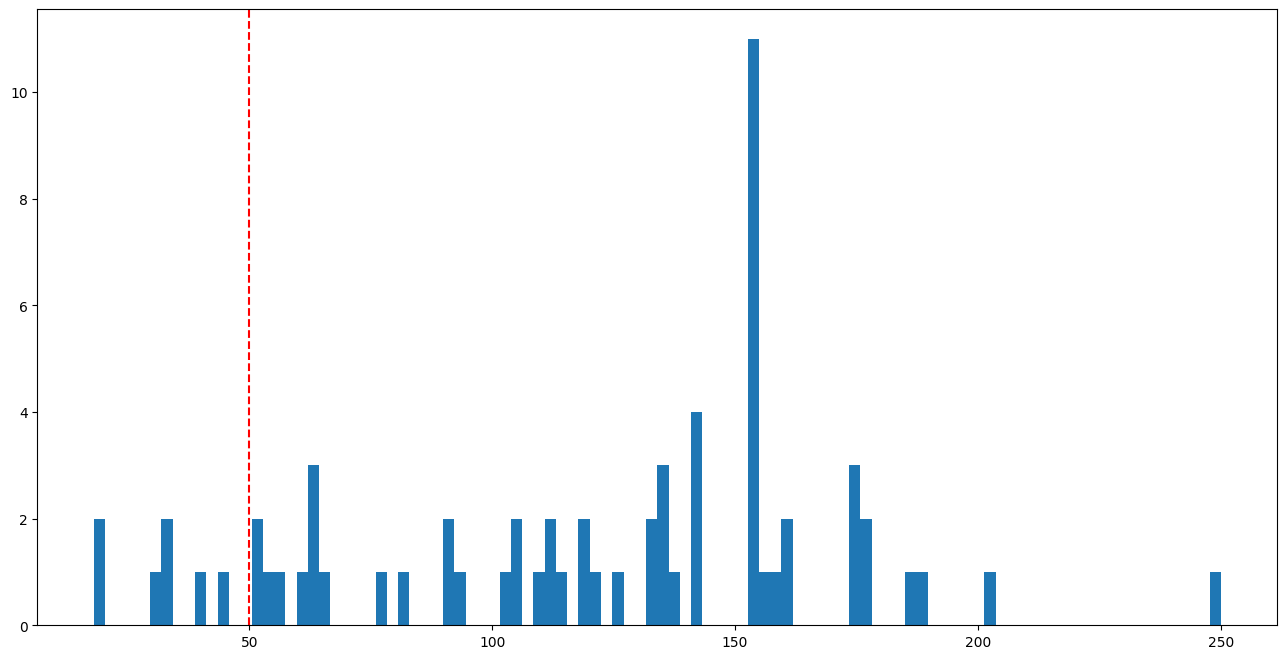

In [25]:
tweet_lengths = [len(tweet) for tweet in X]
plt.figure(figsize=(16,8))
plt.hist(tweet_lengths,
         bins = 100)
plt.axvline( Config.maxlen,
            ls = '--',
            c = 'red')
plt.show()

In [26]:
def tokenise_sentences(tweets: list,
                       tokenizer: object,
                       padding: str,
                       truncating: str,
                       maxlen: int):
  """
  """

  tweets = tokenizer.texts_to_sequences(tweets)

  padded_and_trunc_tweets = pad_sequences(sequences = tweets,
                                          maxlen = maxlen,
                                          truncating = truncating,
                                          padding = padding)

  return padded_and_trunc_tweets

# Try increasing the maxlen ;)

In [27]:
X_train = tokenise_sentences(X_train, tokenizer, Config.padding, Config.truncating, Config.maxlen)
X_test = tokenise_sentences(X_test, tokenizer, Config.padding, Config.truncating, Config.maxlen)

In [28]:
print('Tokenised tweets have shape {}'.format(X_train.shape))

Tokenised tweets have shape (60, 50)


In [29]:
def sentiment_classifier_embedding_max(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.GlobalMaxPooling1D(),
                               tf.keras.layers.Dropout(.3),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ['acc'])

  return model

In [30]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ['acc'])

  return model

In [31]:
sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

In [32]:
# Instantiate model checkpoint callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,verbose=0,mode='auto')

In [33]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [34]:
kf = KFold(n_splits=3,
           shuffle=True,
           random_state=1)

fold = 0

# takes a while to train ...
epochs = 3

model_eval = defaultdict(list)
# 10 fold cross validation strategy
for train_index, test_index in kf.split(X_train):
    cv_X_train, cv_X_val= X_train[train_index], X_train[test_index]
    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    # reinitialise classifers to reset weights
    '''sentiment_classifier_max_model = sentiment_classifier_embedding_max(Config.vocab_size, Config.embedding_dim, Config.maxlen)'''
    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    # train model 1
    '''history_max = sentiment_classifier_max_model.fit(cv_X_train,
                                             cv_y_train,
                                             validation_data = (cv_X_val, cv_y_val),
                                             callbacks = [early_stopping, reduce_lr],
                                             epochs = epochs,
                                             batch_size = 128)'''
    # train model 2
    history_lstm = sentiment_classifier_lstm_model.fit(cv_X_train,
                                               cv_y_train,
                                               validation_data = (cv_X_val, cv_y_val),
                                               callbacks = [early_stopping, reduce_lr],
                                               epochs = epochs,
                                               batch_size = 128)


    # make predictions on hold out validation set for each model
    '''_ , acc = sentiment_classifier_max_model.evaluate(cv_X_val, cv_y_val)'''
    _ , acc2 = sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # calculate performance metric
    '''model_eval['sentiment_classifier_embedding_max'].append(acc)'''
    model_eval['sentiment_classifier_embedding_lstm'].append(acc2)

    fold += 1


'''performance1 = np.mean(model_eval['sentiment_classifier_embedding_max']) - np.std(model_eval['sentiment_classifier_embedding_max'])'''
performance2 = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])

Fold: 0
# train: 40
# val: 20
Epoch 1/3
1/1 [==============================] - 8s 8s/step - loss: 0.6881 - acc: 0.6750 - val_loss: 0.6751 - val_acc: 0.8500 - lr: 0.0010
Epoch 2/3
1/1 [==============================] - 0s 58ms/step - loss: 0.6758 - acc: 0.7000 - val_loss: 0.6605 - val_acc: 0.8500 - lr: 0.0010
Epoch 3/3
1/1 [==============================] - 0s 36ms/step - loss: 0.6384 - acc: 0.8500
Fold: 1
# train: 40
# val: 20
Epoch 1/3
1/1 [==============================] - 6s 6s/step - loss: 0.6812 - acc: 0.8750 - val_loss: 0.6858 - val_acc: 0.6000 - lr: 0.0010
Epoch 2/3
1/1 [==============================] - 0s 57ms/step - loss: 0.6653 - acc: 0.8250 - val_loss: 0.6794 - val_acc: 0.6000 - lr: 0.0010
Epoch 3/3
1/1 [==============================] - 0s 28ms/step - loss: 0.6735 - acc: 0.6000
Fold: 2
# train: 40
# val: 20
Epoch 1/3
1/1 [==============================] - 5s 5s/step - loss: 0.7102 - acc: 0.2500 - val_loss: 0.6928 - val_acc: 0.4500 - lr: 0.0010
Epoch 2/3
1/1 [==============

In [35]:
print('Performance of Embedding max model: {}'.format(performance1))
print('Performance of LSTM model: {}'.format(performance2))

NameError: name 'performance1' is not defined

In [36]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['acc'])

  return model

In [40]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 5))

tune_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)
# Since the dataset is large ... lets reduce the dataset size
history = tune_model.fit(cv_X_train[:60],
                         cv_y_train[:60],
                         validation_data = (cv_X_val[:60], cv_y_val[:60]),
                         callbacks = [lr_schedule],
                         epochs = 30,
                         batch_size = 16)

Epoch 1/30
3/3 [==============================] - 7s 569ms/step - loss: 0.6869 - acc: 0.7000 - val_loss: 0.6929 - val_acc: 0.4500 - lr: 1.0000e-06
Epoch 2/30
3/3 [==============================] - 1s 197ms/step - loss: 0.6896 - acc: 0.6000 - val_loss: 0.6929 - val_acc: 0.4500 - lr: 1.5849e-06
Epoch 3/30
3/3 [==============================] - 1s 211ms/step - loss: 0.6895 - acc: 0.5000 - val_loss: 0.6928 - val_acc: 0.4500 - lr: 2.5119e-06
Epoch 4/30
3/3 [==============================] - 1s 198ms/step - loss: 0.6891 - acc: 0.5750 - val_loss: 0.6926 - val_acc: 0.4500 - lr: 3.9811e-06
Epoch 5/30
3/3 [==============================] - 0s 45ms/step - loss: 0.6902 - acc: 0.6500 - val_loss: 0.6924 - val_acc: 0.4500 - lr: 6.3096e-06
Epoch 6/30
3/3 [==============================] - 1s 202ms/step - loss: 0.6910 - acc: 0.5000 - val_loss: 0.6921 - val_acc: 0.4500 - lr: 1.0000e-05
Epoch 7/30
3/3 [==============================] - 1s 207ms/step - loss: 0.6857 - acc: 0.7250 - val_loss: 0.6914 - val_a

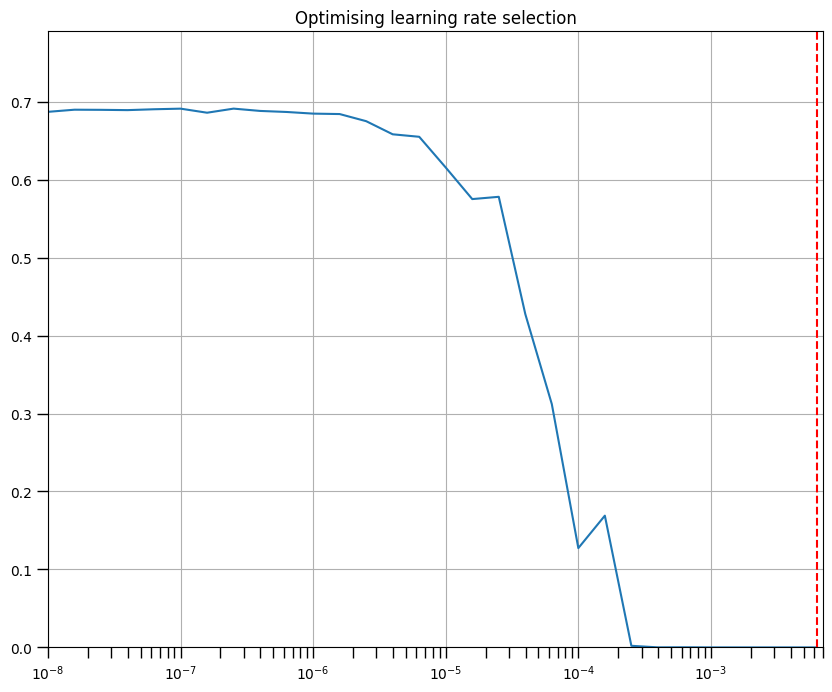

In [41]:
learning_rates = 1e-8 * (10 ** ((np.arange(30))/5))
best_lr = learning_rates[np.argmin(history.history['loss'])]
#without removing this colab will die
tune_model=[]
plt.figure(figsize = (10,8))
plt.grid(True)
plt.semilogx(learning_rates, history.history["loss"])
plt.tick_params('both', length=8, width=1, which = 'both')
plt.axis([1e-8,.007,0,.79])

plt.axvline(learning_rates[np.argmin(history.history['loss'])],
            ls = '--',
            c = 'red')
plt.title('Optimising learning rate selection')
plt.show()

In [42]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen, best_lr):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name = 'lstm_layer')),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu, name = 'dense_layer_1'),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu,name = 'dense_layer_2'),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,name = 'output_layer')
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(best_lr),
                metrics = ['acc'])

  return model

In [46]:
final_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen, best_lr)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=0,mode='auto')

# The below will only save if the val accuracy improves. This means we can later load the best model without worrying about overtraining.
'''model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Internship/new_combined_tweets_with_sentiment_labeled 2.csv',
                                                               save_weights_only=False,
                                                               monitor='val_acc',
                                                               mode='max',
                                                               save_best_only=True)'''
history = final_model.fit(X_train[:-6],
                         y_train[:-6],
                         validation_data = (X_train[-6:], y_train[-6:]),
                         callbacks = [reduce_lr,model_checkpoint_callback],
                         epochs = 10,
                         batch_size = 16)

Epoch 1/10
4/4 [==============================] - 6s 435ms/step - loss: 0.6221 - acc: 0.7222 - val_loss: 0.4341 - val_acc: 0.8333 - lr: 0.0063
Epoch 2/10
4/4 [==============================] - 1s 123ms/step - loss: 0.5469 - acc: 0.7407 - val_loss: 0.3227 - val_acc: 0.8333 - lr: 0.0063
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 0.2882 - acc: 0.8333

FailedPreconditionError: /content/drive/MyDrive/Internship/new_combined_tweets_with_sentiment_labeled 2.csv is not a directory

In [47]:
final_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 29ms/step - loss: 1.1510 - acc: 0.6667


[1.1510310173034668, 0.6666666865348816]